# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import patches
import keras.backend as K

# Model

In [4]:
feature_extractor_seq_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(480, 480, 3)),

    # first block
    tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # second block
    tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=2, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # third block
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # fourth block
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),

    # final block
    tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same',
                           activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.LayerNormalization(),
])

feature_extractor_seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 64)      9472      
                                                                 
 layer_normalization (LayerN  (None, 240, 240, 64)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 192)       110784    
                                                                 
 layer_normalization_1 (Laye  (None, 60, 60, 192)      384       
 rNormalization)                                                 
                                                        

In [5]:
func_input = tf.keras.layers.Input(shape=(480, 480, 3), name='input')

# get the feature extractor
x = feature_extractor_seq_model(func_input)

# add a dense layer after the feature extractor
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(7 * 7 * 3, activation='sigmoid', kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = tf.keras.layers.Reshape((7, 7, 3))(x)  # reshape the output to (7, 7, 3)

proto_model = tf.keras.Model(inputs=func_input, outputs=x)
proto_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 1024)        18267840  
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 147)               2408595   
                                                                 
 reshape (Reshape)           (None, 7, 7, 3)           0         
                                                                 
Total params: 20,676,435
Trainable params: 20,676,435
Non-trainable params: 0
_________________________________________________________________


# Loss Function

In [6]:
def locals_loss(alpha=1, beta=5.0, gamma=5.0):  # alpha: correlation weight, beta: localization weight, gamma: objectness weight
    def loss_func(y_true, y_predicted):
        # extract x, y, and objectness mask
        x_true, y_true_val, obj_true = y_true[..., 0], y_true[..., 1], y_true[..., 2]
        x_pred, y_pred, obj_pred = y_predicted[..., 0], y_predicted[..., 1], y_predicted[..., 2]

        # compute localization loss (only for cells with objects)
        obj_mask = obj_true  # 1 where object exists, 0 otherwise
        loss_x = tf.math.square(x_true - x_pred) * obj_mask
        loss_y = tf.math.square(y_true_val - y_pred) * obj_mask
        loc_loss = tf.reduce_sum(loss_x) + tf.reduce_sum(loss_y)

        # compute objectness loss
        obj_loss = tf.keras.losses.binary_crossentropy(obj_true, obj_pred, from_logits=False)
        obj_loss = tf.reduce_sum(obj_loss) / (tf.reduce_sum(obj_mask) + 1e-8)

        # compute correlation loss (using obj_mask)
        def pearson_corr(a, b, mask):
            a = a * mask
            b = b * mask
            mean_a = tf.reduce_sum(a) / (tf.reduce_sum(mask) + 1e-8)
            mean_b = tf.reduce_sum(b) / (tf.reduce_sum(mask) + 1e-8)

            num = tf.reduce_sum((a - mean_a) * (b - mean_b) * mask)
            denom = tf.sqrt(tf.reduce_sum(tf.square(a - mean_a) * mask)) * tf.sqrt(tf.reduce_sum(tf.square(b - mean_b) * mask))
            return num / (denom + 1e-8)

        corr_true = pearson_corr(x_true, y_true_val, obj_mask)
        corr_pred = pearson_corr(x_pred, y_pred, obj_mask)
        corr_loss = tf.abs(corr_true - corr_pred)

        # calculate total loss
        total_loss = beta * loc_loss + gamma * obj_loss + alpha * corr_loss
        return total_loss

    return loss_func

# Dataset

In [7]:
dataset_path = r"D:\Education\Code Bases\Python\LOCALS\LOCALS-Dataset\dataset3" # dataset path
dataset = tf.data.Dataset.load(dataset_path) # load dataset
batch_size = 1 # batch size 1 due to small dataset size

buffer_size = 499
dataset = dataset.shuffle(buffer_size, seed=42, reshuffle_each_iteration=False)

Dataset Partitioning

In [8]:
# function to split the dataset into train, test and validation datasets (80%, 10%, 10%)

def splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
    val_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE) + int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1
train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO)

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Dataset Visualization

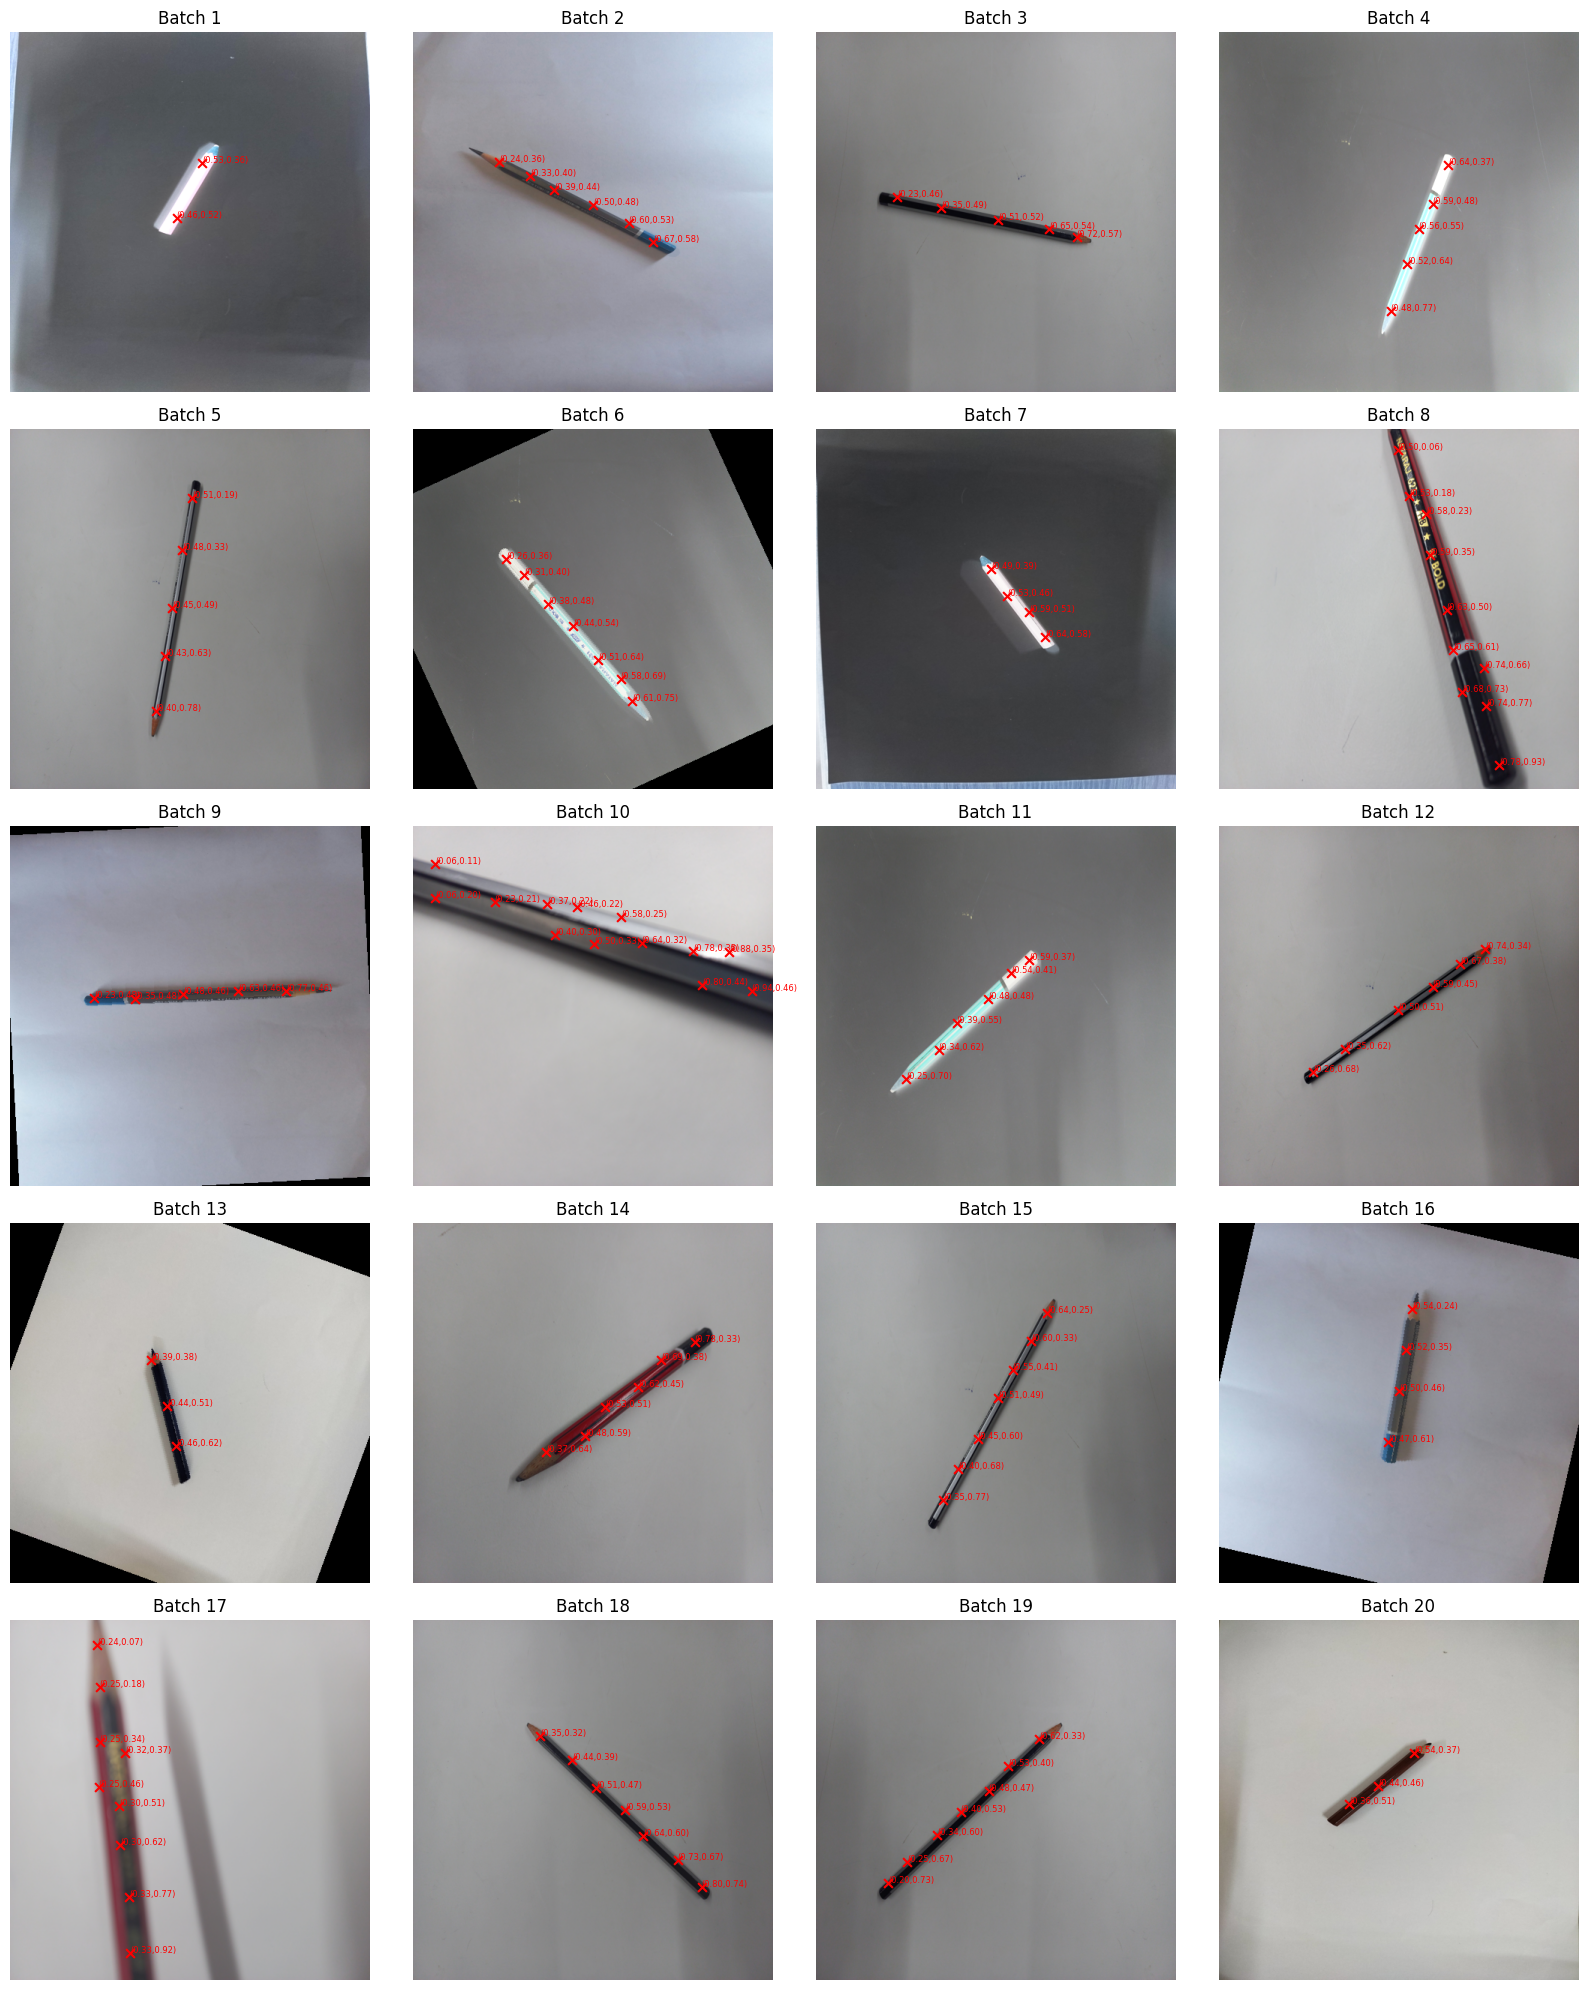

In [10]:
# function to visualize any given dataset

def visualize_dataset(dataset, num_batches=20, grid_rows=5, grid_cols=4):
  fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
  axes = axes.flatten()

  for batch_idx, (image, label) in enumerate(dataset.take(num_batches)):
    if batch_idx >= len(axes):
      break

    image_numpy = image[0].numpy()
    if image_numpy.max() <= 1.0:
      image_numpy = (image_numpy * 255).astype(np.uint8)

    label_numpy = label[0].numpy()
    img_height, img_width = image_numpy.shape[:2]

    ax = axes[batch_idx]
    ax.axis('off')

    if image_numpy.ndim == 2:
      ax.imshow(image_numpy, cmap='gray')
    else:
      ax.imshow(image_numpy)

    for row in range(7):
      for col in range(7):
        x, y, obj = label_numpy[row, col]
        if obj == 1:
          x_coord = x * img_width
          y_coord = y * img_height
          ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
          ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

    ax.set_title(f"Batch {batch_idx + 1}")

  for i in range(batch_idx + 1, len(axes)):
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

# call the visualization function
visualize_dataset(dataset)

# Training

In [11]:
# train the model

custom_loss = locals_loss()
proto_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss=custom_loss, metrics=['accuracy'])
history = proto_model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
399/399 [==============================] - 43s 31ms/step - loss: 3.9781 - accuracy: 0.7594
Epoch 2/100
399/399 [==============================] - 29s 31ms/step - loss: 4.5329 - accuracy: 0.7843
Epoch 3/100
399/399 [==============================] - 27s 31ms/step - loss: 4.7676 - accuracy: 0.7978
Epoch 4/100
399/399 [==============================] - 18s 31ms/step - loss: 3.7578 - accuracy: 0.7967
Epoch 5/100
399/399 [==============================] - 16s 32ms/step - loss: 3.5379 - accuracy: 0.7926
Epoch 6/100
399/399 [==============================] - 15s 31ms/step - loss: 3.4570 - accuracy: 0.8145
Epoch 7/100
399/399 [==============================] - 16s 31ms/step - loss: 2.6165 - accuracy: 0.8178
Epoch 8/100
399/399 [==============================] - 17s 31ms/step - loss: 2.2233 - accuracy: 0.8294
Epoch 9/100
399/399 [==============================] - 74s 30ms/step - loss: 2.2940 - accuracy: 0.8338
Epoch 10/100
399/399 [==============================] - 23s 32ms/step - l

# Saving and Loading Model

In [13]:
proto_model.save(r"D:\Education\Code Bases\Python\LOCALS\Testing Model\models\LOCALS2.keras") # save the model

In [ ]:
proto_model = tf.keras.models.load_model(r"D:\Education\Code Bases\Python\LOCALS\Testing Model\models\LOCALS2.keras", custom_objects={'loss_func': locals_loss()}) # and load the model

# Graphing Loss

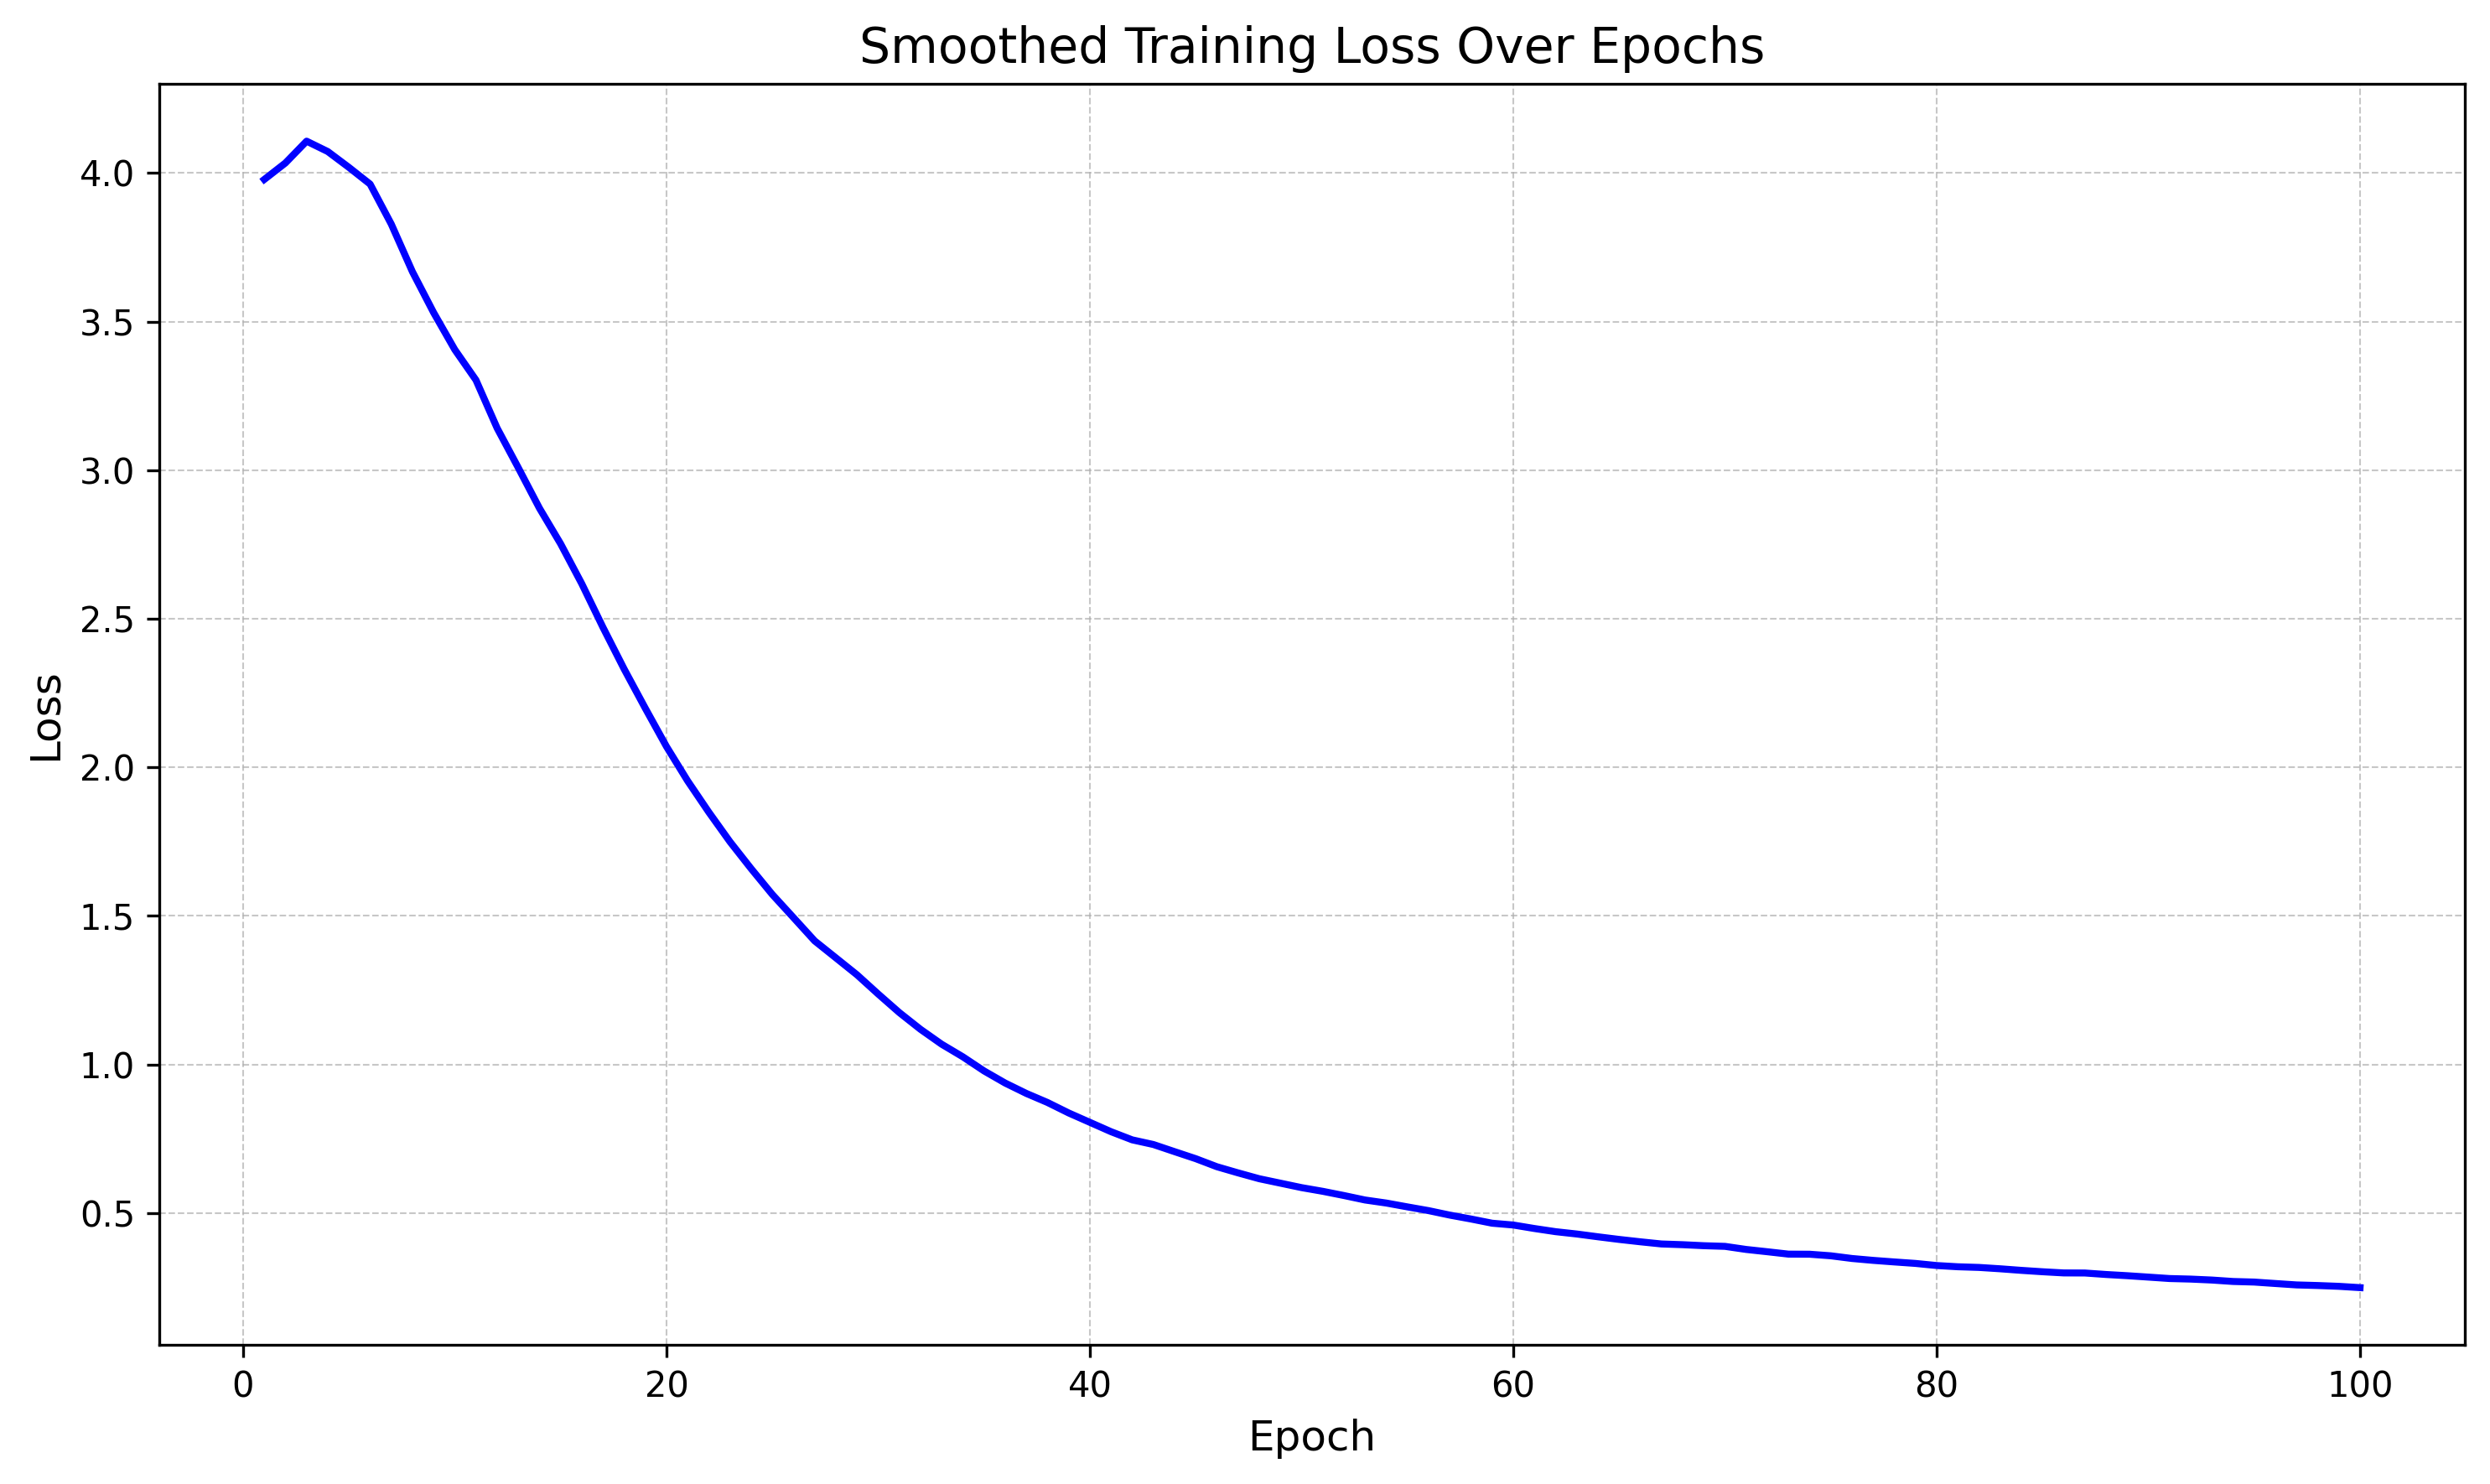

In [16]:
def smooth_curve(points, factor=0.9):
    # applies exponential smoothing to a curve
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# extract raw loss and val_loss from history
loss = history.history['loss']
val_loss = history.history.get('val_loss', None)

# smooth the losses
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss) if val_loss is not None else None

# plot the smoothed losses
epochs = range(1, len(smooth_loss) + 1)
plt.figure(figsize=(10, 6), dpi=300)  # High-res
plt.plot(epochs, smooth_loss, color='blue', linewidth=2)
plt.title(r'Smoothed Training Loss Over Epochs', fontsize=14)
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("smoothed_training_loss.png", dpi=300)
plt.show()

# Testing

1/1 [==============================] - 0s 19ms/step


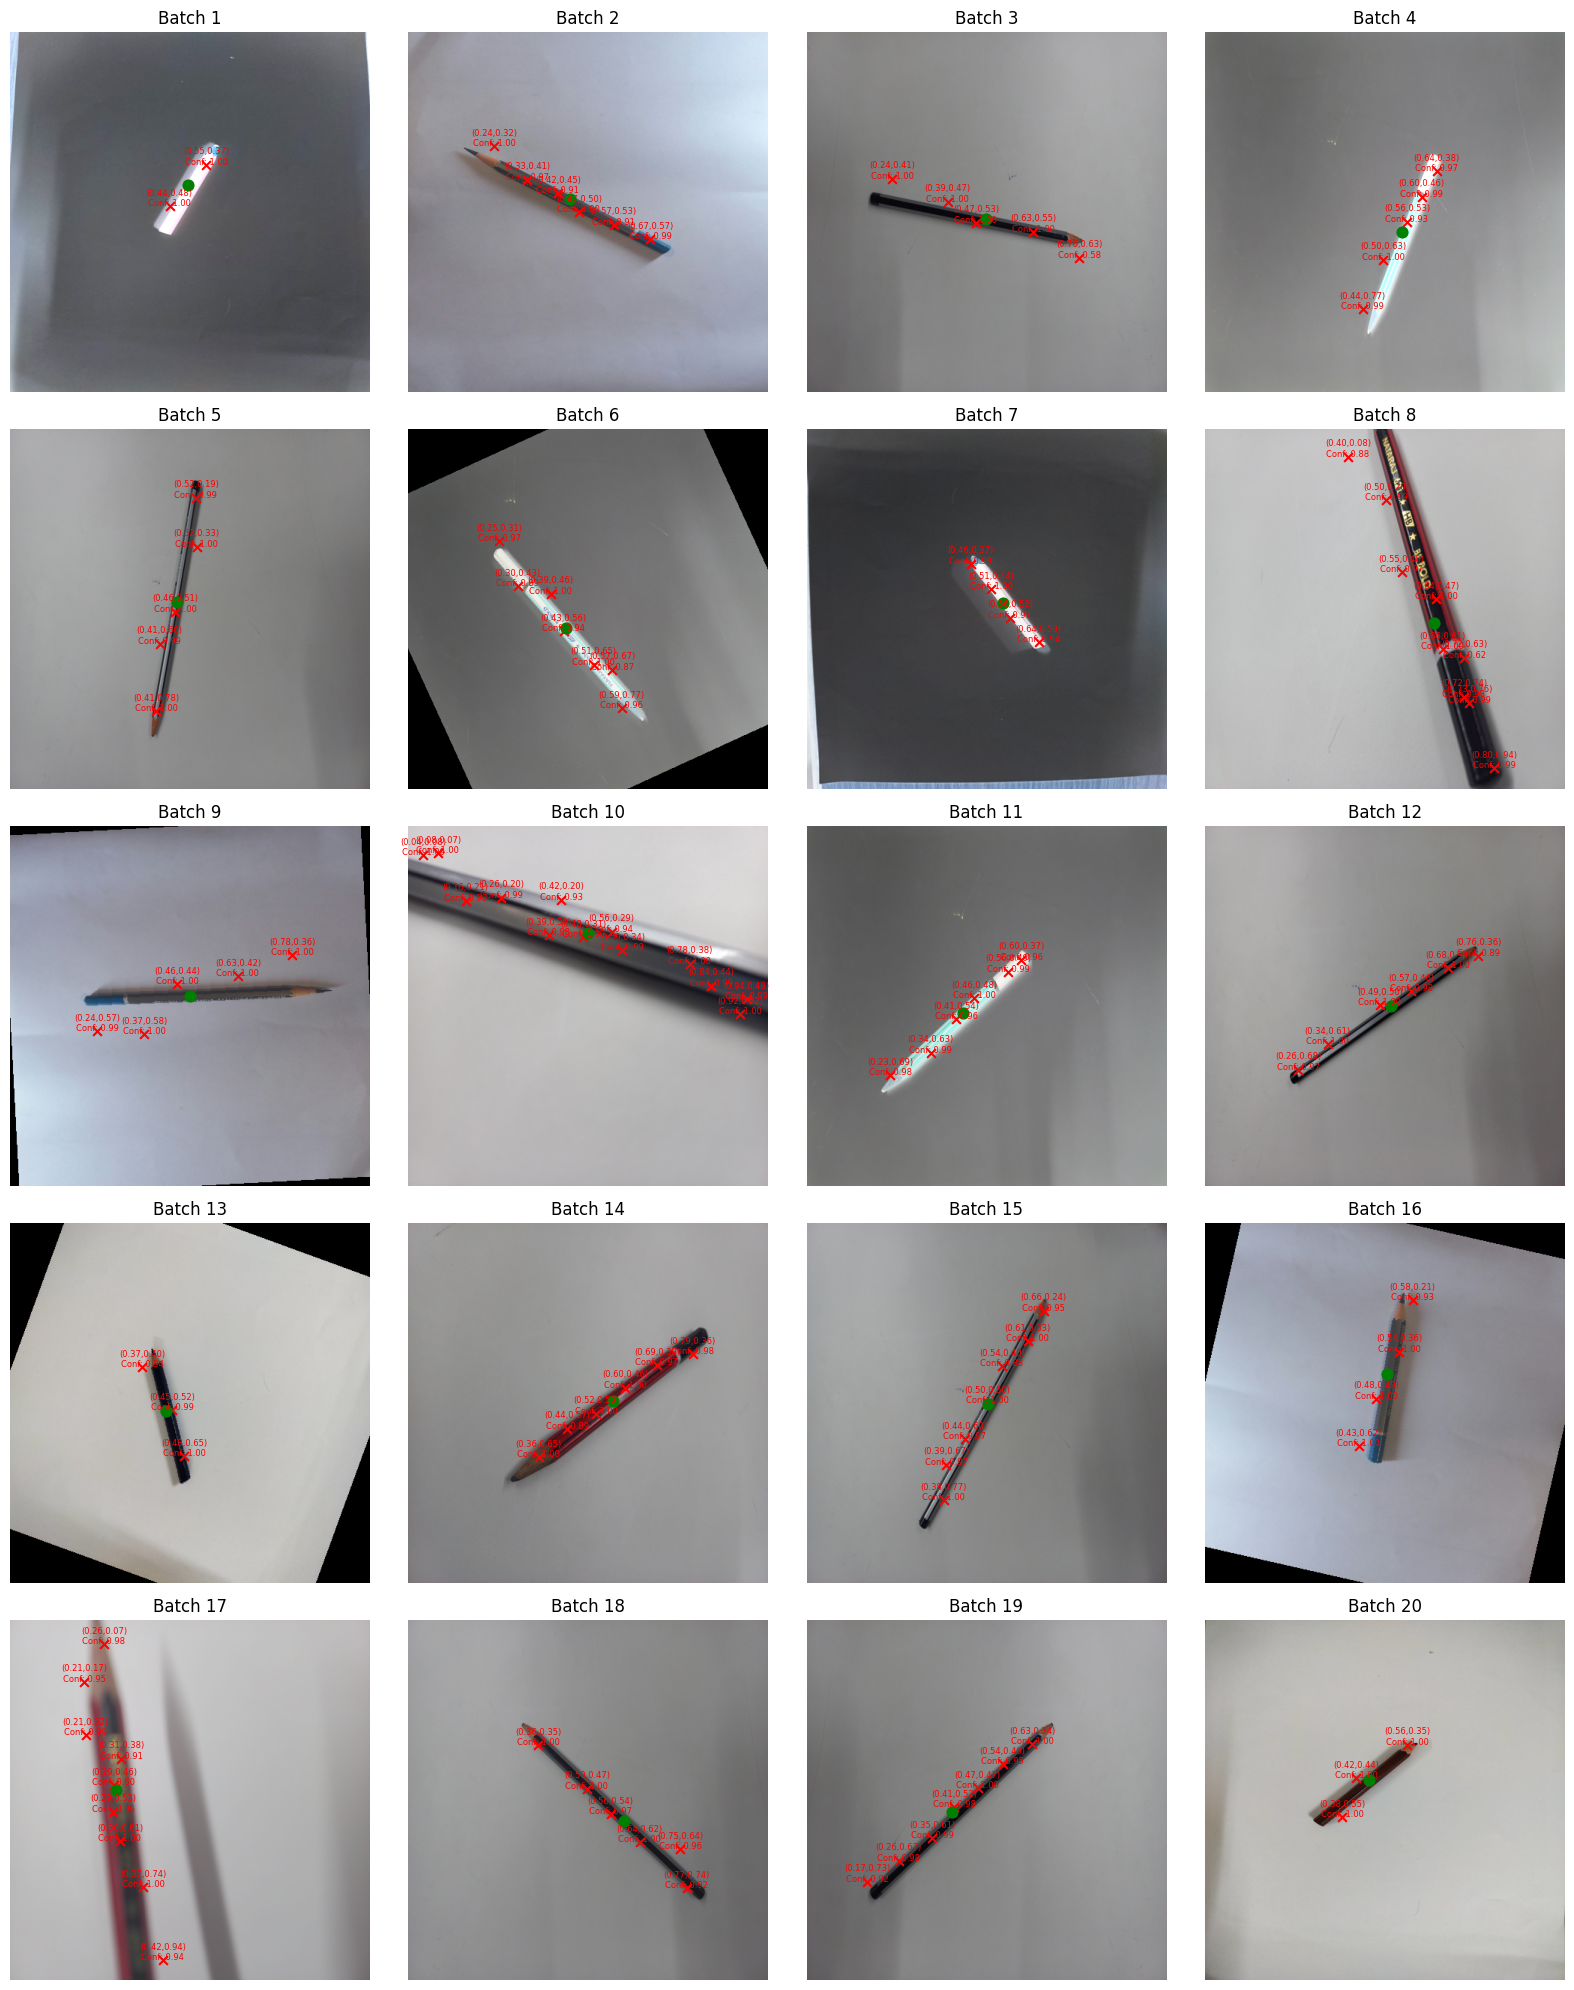

In [17]:
# function to visualize the predictions of the model

def visualize_predictions(model, dataset, num_batches=20, grid_rows=5, grid_cols=4):
    
    # create a grid of subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    axes = axes.flatten()

    for batch_idx, (image, label) in enumerate(dataset.take(num_batches)):
        if batch_idx >= len(axes):
            break

        image_numpy = image[0].numpy()  # extract the first image from batch and convert to numpy
        if image_numpy.max() <= 1.0:  # if normalized, scale to 255
            image_numpy = (image_numpy * 255).astype(np.uint8)

        label_numpy = label[0].numpy()  # extract label

        # model expects input shape (None, 480, 480, 3), so expand dimensions if necessary
        image_input = np.expand_dims(image_numpy, axis=0)  # shape becomes (1, 480, 480, 3)
        predictions = model.predict(image_input)[0]  # get predictions and remove batch dimension

        img_height, img_width = image_numpy.shape[:2]

        ax = axes[batch_idx]
        ax.imshow(image_numpy)
        ax.set_title(f"Batch {batch_idx + 1}")
        ax.axis('off')

        x_coords, y_coords = [], []

        for row in range(7):
            for col in range(7):
                x, y, obj = predictions[row, col]
                if obj > 0.5:  # only visualize if objectness is significant
                    x_coord = x * img_width  # scale up x and y coordinates from normalized state
                    y_coord = y * img_height

                    ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                    ax.text(
                        x_coord, y_coord,
                        f"({x:.2f},{y:.2f})\nConf: {obj:.2f}",
                        fontsize=6, color='red', ha='center'
                    )

                    x_coords.append(x_coord)
                    y_coords.append(y_coord)

        # compute and plot the average prediction point in green
        if x_coords and y_coords:
            avg_x = np.mean(x_coords)
            avg_y = np.mean(y_coords)
            ax.scatter(avg_x, avg_y, color='green', marker='o', s=60, label="Avg")

    # hide unused subplots
    for i in range(batch_idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# call the function
visualize_predictions(proto_model, dataset)

# Visualizing What the Model Sees

1/1 [==============================] - 0s 145ms/step


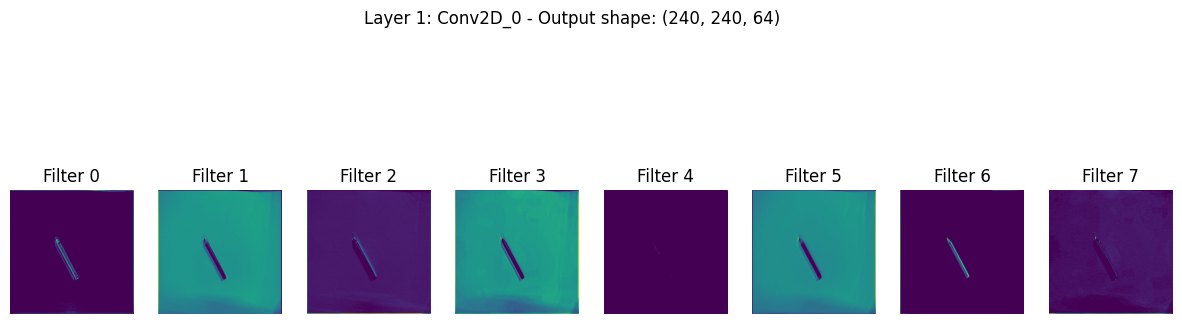

1/1 [==============================] - 0s 180ms/step


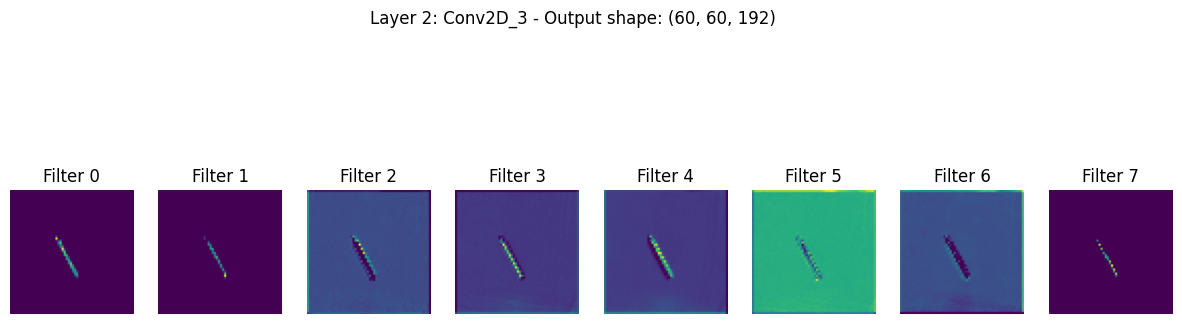

1/1 [==============================] - 0s 334ms/step


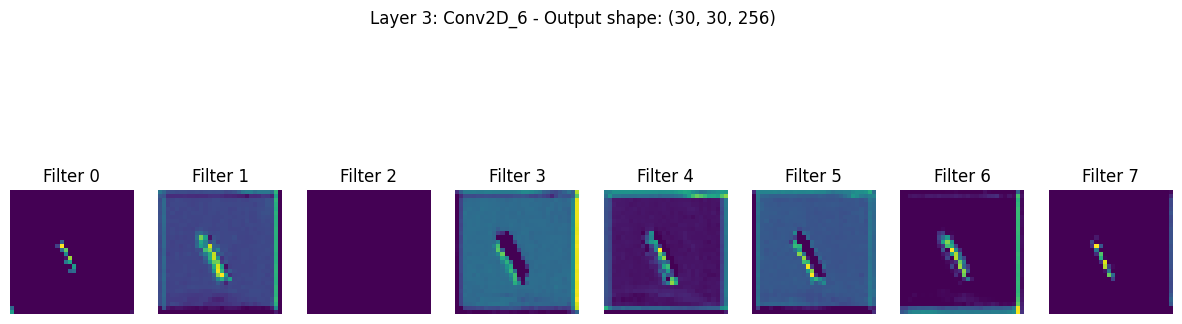

1/1 [==============================] - 0s 293ms/step


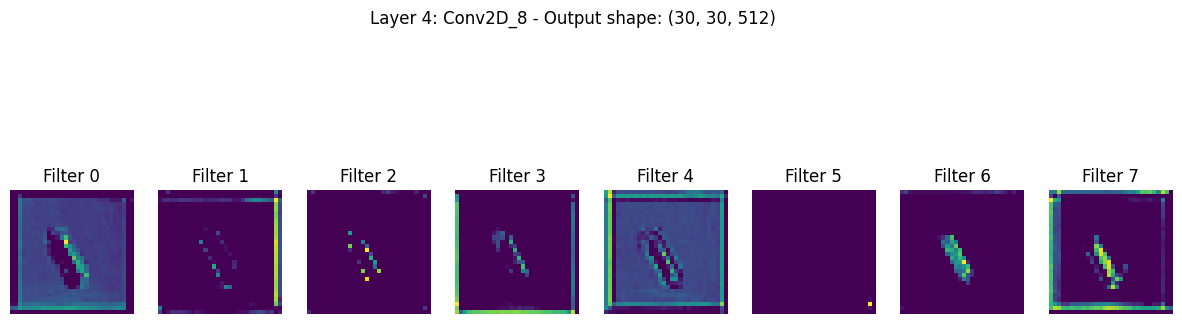

1/1 [==============================] - 0s 386ms/step


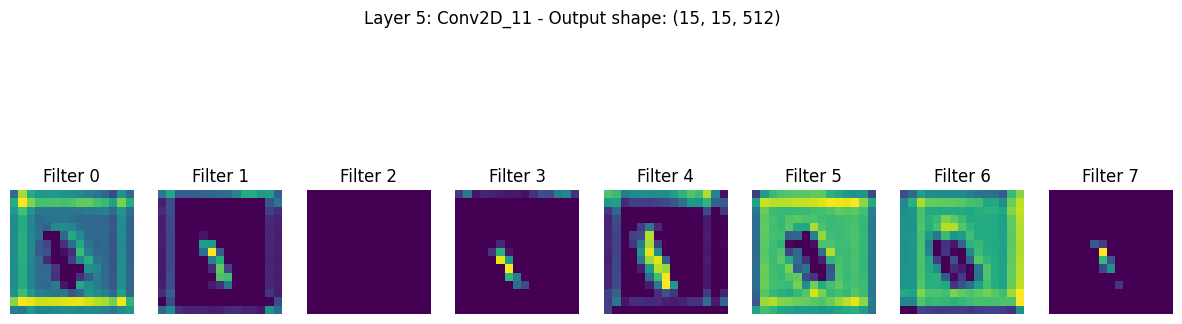

1/1 [==============================] - 0s 451ms/step


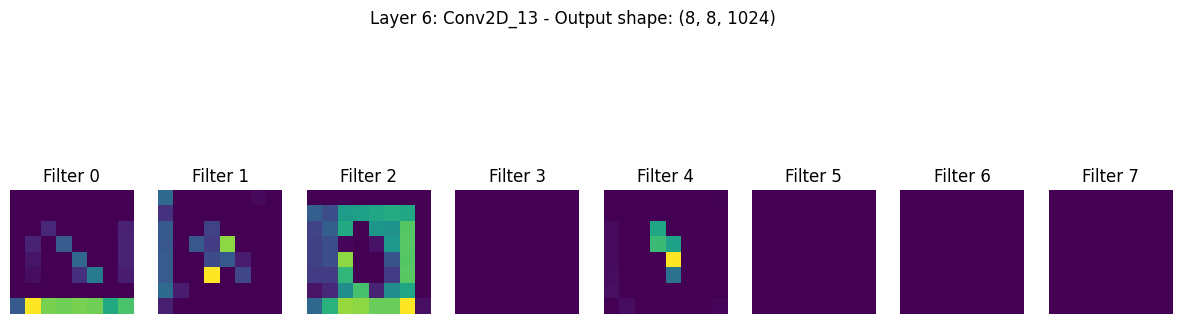

1/1 [==============================] - 1s 540ms/step


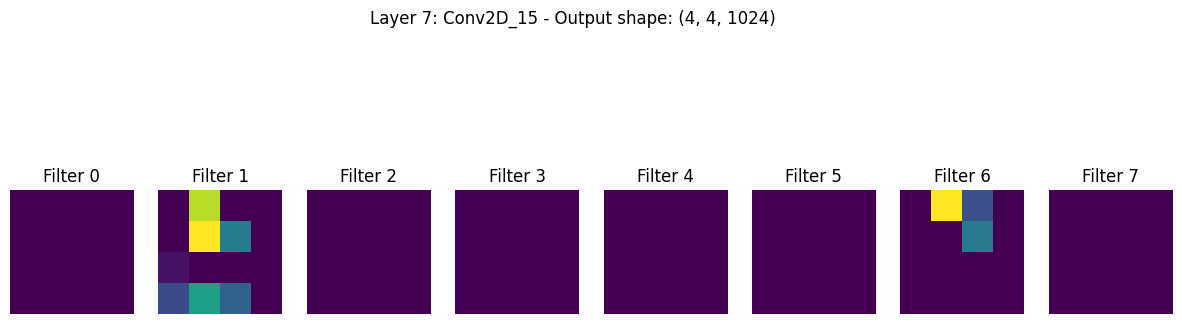

In [18]:
# indeces of all conv layers in the model
conv_indices = [0, 3, 6, 8, 11, 13, 15]

for batch_idx, (image, label) in enumerate(test_dataset):
  if batch_idx == 4:  # choosing a good image
    image_numpy = image[0].numpy()  # extract the first image from batch and convert to numpy
    break

image_numpy = np.expand_dims(image_numpy, axis=0)

for i, idx in enumerate(conv_indices):
    submodel = tf.keras.models.Sequential(feature_extractor_seq_model.layers[:idx+1])
    feature_maps = submodel.predict(image_numpy)

    # select first 8 filters to display
    n_filters = min(8, feature_maps.shape[-1])
    fig, axs = plt.subplots(1, n_filters, figsize=(15, 5))
    fig.suptitle(f"Layer {i+1}: Conv2D_{idx} - Output shape: {feature_maps.shape[1:]}")

    for j in range(n_filters):
        axs[j].imshow(feature_maps[0, :, :, j], cmap='viridis')
        axs[j].axis('off')
        axs[j].set_title(f"Filter {j}")
    plt.show()

# Evaluation (Correlation Error)

In [19]:
def normalize_image(image):
    return (image * 255).astype(np.uint8) if image.max() <= 1 else image

In [20]:
def correlation_error(model, dataset, num_batches=100):
    images = []
    labels = []

    # gather all images and labels into lists first
    for batch_idx, (image, label) in enumerate(dataset.take(num_batches)):
        if batch_idx >= num_batches:
            break

        image_numpy = image[0].numpy()
        image_numpy = normalize_image(image_numpy)

        image_input = np.expand_dims(image_numpy, axis=0)
        images.append(image_input)

        labels.append(label[0].numpy())

    # stack all image inputs into a single batch
    images_batch = np.vstack(images)  # shape: (num_batches, 480, 480, 3)
    predictions_batch = model.predict(images_batch) # predict output for all the images

    correlations = []

    for i in range(len(predictions_batch)): # iterate through predictions
        predictions = predictions_batch[i] # get the ith prediction
        label_numpy = labels[i] # and the ith label

        points = [] # we make a list called points to store all significant points (objectness > 0.9) from both labels and predictions
        for box in predictions:
            for row in box:
                if row[-1] > 0.9: # row[-1] refers to the objectness value
                    points.append(row[:2])

        for box in label_numpy:
            for row in box:
                if row[-1] > 0:
                    points.append(row[:2])

        if len(points) >= 2: # calculate correlation coefficient for ith label and prediction
            points = np.array(points)
            correlation = np.corrcoef(points[:, 0], points[:, 1])[0, 1]
            correlations.append(np.abs(correlation)) # append correlation value to a global variable to be used later

    return np.mean(correlations) if correlations else 0.0 # find mean correlation

print("Mean Correlation Precision: ", correlation_error(proto_model, dataset, 100) * 100, "%")

4/4 [==============================] - 3s 243ms/step
Mean Correlation Precision:  90.21381663763705 %


# Finding Classification Recall, Precision and F1 Score

In [21]:
def find_recall_precision_f1_score(model, dataset, num_batches=100, threshold=0.9):

  images = []
  labels = []
  true_positives = 0
  false_positives = 0
  false_negatives = 0

  # gather all images and labels into lists first
  for batch_idx, (image, label) in enumerate(dataset.take(num_batches)):
    if batch_idx >= num_batches:
      break

    image_numpy = image[0].numpy()
    image_numpy = normalize_image(image_numpy)

    image_input = np.expand_dims(image_numpy, axis=0)
    images.append(image_input)

    labels.append(label[0].numpy())

  # stack all image inputs into a single batch
  images_batch = np.vstack(images)  # shape: (num_batches, 480, 480, 3)

  predictions_batch = model.predict(images_batch) # predict output for all the images

  for i in range(len(predictions_batch)):
    predictions = predictions_batch[i]
    label_numpy = labels[i]

    n = len(predictions)
    for j in range(n):
      for k in range(n):
        # if predictions say there is a LaSO, and so does the label -> true positive
        if predictions[j][k][-1] > threshold and label_numpy[j][k][-1] > 0:
          true_positives += 1

        # if the predictions say there is a LaSO, but the label does not -> false positive
        elif predictions[j][k][-1] > threshold and label_numpy[j][k][-1] == 0:
          false_positives += 1

        # if the predictions say there is not a LaSO, but the label does -> false negative
        elif predictions[j][k][-1] == 0 and label_numpy[j][k][-1] > 0:
          false_negatives += 1

  recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
  precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  return recall, precision, f1_score

recall, precision, f1_score = find_recall_precision_f1_score(proto_model, test_dataset, 100)
print("Classification Recall is:", recall)
print("Classification Precision is:", precision)
print("Classification F1 Score is:", f1_score)

2/2 [==============================] - 1s 1s/step
Classification Recall is: 1.0
Classification Precision is: 0.9917695473251029
Classification F1 Score is: 0.9958677685950413


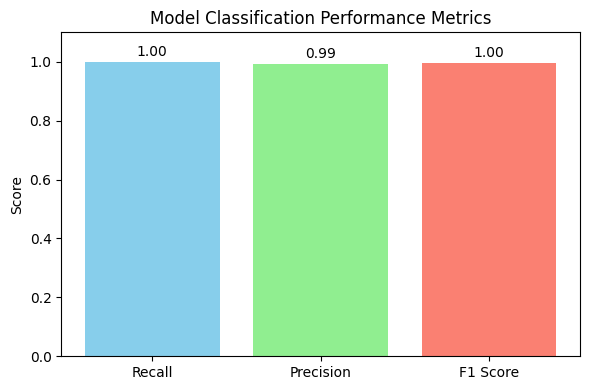

<Figure size 640x480 with 0 Axes>

In [23]:
metrics = ['Recall', 'Precision', 'F1 Score']
values = [recall, precision, f1_score]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title('Model Classification Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()
plt.savefig("recall-precision-f1score.png", dpi=300)